In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error
import sklearn.metrics 
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
%matplotlib inline
from pmdarima.arima import auto_arima

In [117]:
# Carregando os dados:
df=pd.read_csv('Sunspots.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df[['Monthly Mean Total Sunspot Number']].groupby('Date').sum()
df.rename(columns={'Monthly Mean Total Sunspot Number': 'sunspots'}, inplace = True)
# reduzindo amostra:
df_sunspots = df.iloc[3228:3265]
#df_sunspots=df.dropna()
df_sunspots.head(2)

,sunspots
Date,
2018-01-31,6.8
2018-02-28,10.7


In [39]:
df_sunspots.iloc[[0, -1]]

,sunspots
Date,
2018-01-31,6.8
2021-01-31,10.4


In [40]:
# conhecendo os dados:
df_sunspots.head(10)

,sunspots
Date,
2018-01-31,6.8
2018-02-28,10.7
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.1
2018-06-30,15.6
2018-07-31,1.6
2018-08-31,8.7
2018-09-30,3.3


In [41]:
# conhecendo os dados:
df_sunspots.tail(24)

,sunspots
Date,
2019-02-28,0.8
2019-03-31,9.4
2019-04-30,9.1
2019-05-31,9.9
2019-06-30,1.2
2019-07-31,0.9
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


In [42]:
# conhecendo os dados:
df_sunspots.info()
df_sunspots.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2018-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sunspots  37 non-null     float64
dtypes: float64(1)
memory usage: 592.0 bytes


,sunspots
count,37.000000
mean,6.513514
std,6.903468
min,0.200000
25%,1.200000
50%,5.200000
75%,9.100000
max,34.000000


In [43]:
df.isna().values.any()

False

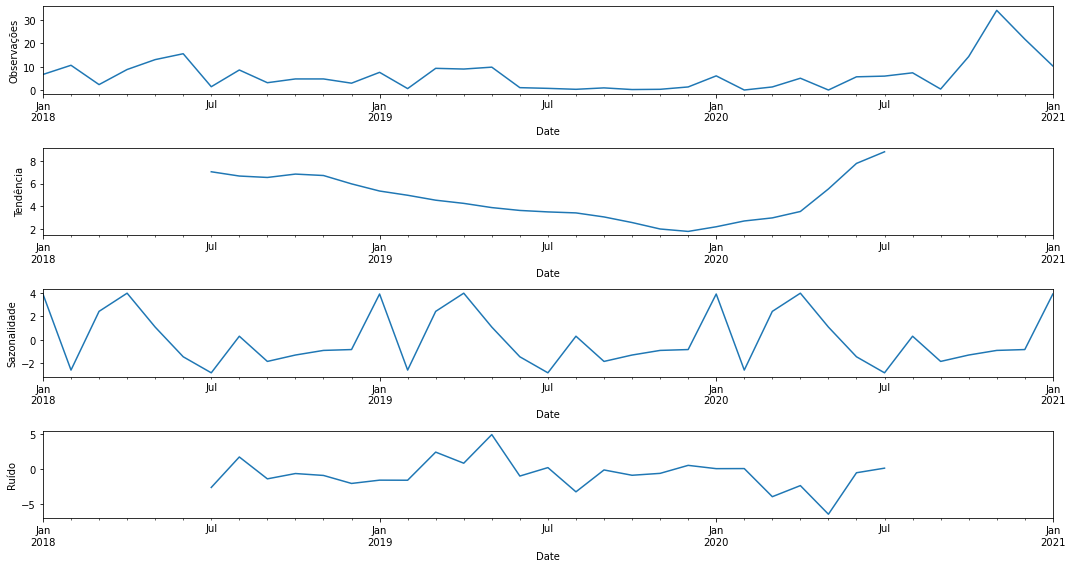

In [44]:
# decompondo a série:
seasonplot = seasonal_decompose(df_sunspots)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1, ylabel='Observações') 
seasonplot.trend.plot(ax=ax2, ylabel='Tendência') 
seasonplot.seasonal.plot(ax=ax3, ylabel='Sazonalidade')
seasonplot.resid.plot(ax=ax4, ylabel='Ruído') 
plt.tight_layout()


In [45]:
# aplicando o teste Dickey-Fuller Aumentado (ADF) para verificar estacionariedade na série:

# Extraindo a coluna que contém os dados da série temporal
dados_serie = df_sunspots['sunspots']
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal é estacionária (rejeita-se a hipótese nula).
Estatística do teste ADF: -3.3025551726974602
Valor-p: 0.014764643833383143


In [43]:
# em caso negativo, para teste do melhor resultado da série para se tornar estacionária, pode ser aplicado a diferenciação:
#diff_1 = dados_serie.diff().dropna()
# testar novamente por ADF

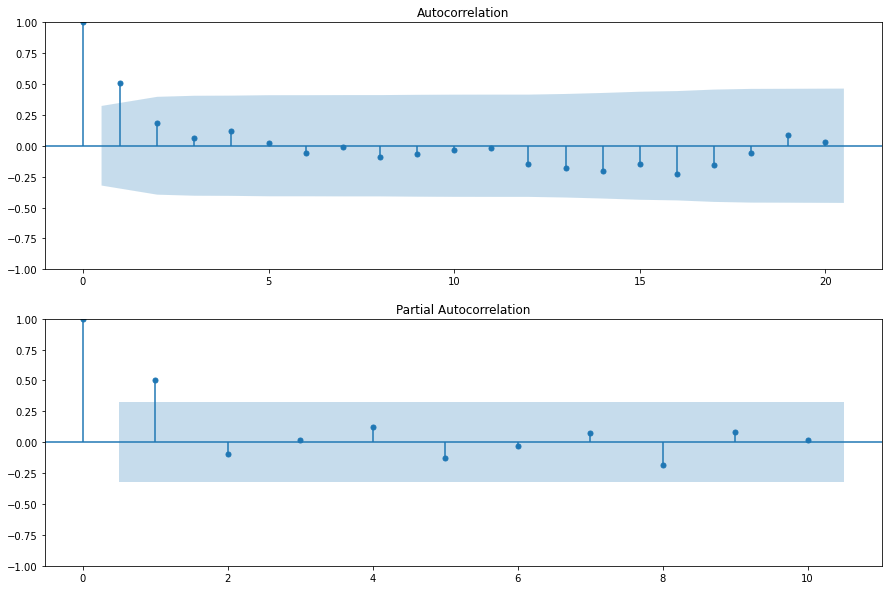

In [48]:
# verificando autocorrelação e autocorrelação parcial:
# auto-regressão (p) = autorrelação; média móvel (q)= autocorrelação parcial.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_sunspots.values.squeeze(), lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(df_sunspots.values.squeeze(), lags= 10, ax=ax2, method='ywm')
plt.show()

In [49]:
# Aplicando método Auto ARIMA (já pode-se definir max e min valores dos parâmetros para facilitar o código):
# A sazonalidade, se mensal, usar m=12; Por padrão o P iniciará em 0 e o máximo será 2; o Q por padrão será 1 e o máximo, por padrão, será 2; o d será 1 e o máximo, por padrão, será 2; o D será 1, por padrão já é 1.
# Serão gerados vários modelos ARIMA e os seus respectivos AIC's e BICS (critérios de informação).
# Stepwise permite diminuir o número de modelos gerados, deixa o código mais leve.
stepwise=auto_arima(df_sunspots,start_p=0, start_q=0,max_p=3,max_q=3,m=12,start_P=0,
                     seasonal=True,d=0,D=1,trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=190.354, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=189.838, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=183.715, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=185.098, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=188.062, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=183.493, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=183.680, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=185.490, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=185.490, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=185.689, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=186.977, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=181.595, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=181.846, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12]             

In [50]:
# verificando resultado e menor AIC:
stepwise

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [51]:
stepwise.aic()

181.5946890082675

In [52]:
# testando mais um modelo, com parâmetro diferente, por exemplo de sazonalidade D:
stepwise1=auto_arima(df_sunspots,start_p=0, start_q=0,max_p=3,max_q=3,m=21,start_P=0,
                     seasonal=True,d=0,D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[21] intercept   : AIC=252.146, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[21] intercept   : AIC=250.957, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[21] intercept   : AIC=242.716, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[21] intercept   : AIC=244.338, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[21]             : AIC=272.996, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[21] intercept   : AIC=242.232, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[21] intercept   : AIC=242.715, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[21] intercept   : AIC=244.715, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[21] intercept   : AIC=243.988, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[21] intercept   : AIC=243.988, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[21] intercept   : AIC=243.525, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[21] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[21]             : AIC=246.706, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[21] intercept
Total fit time: 0.867 seconds


In [53]:
# verificando demais resultados com menores AIC:
stepwise1
stepwise1.aic()

242.23190384778889

In [62]:
# validar modelo
# separando os dados de treino e teste: os dados de treino (70% inicial da amostra) serão usado para treinar o modelo ARIMA e os dados de teste(30% restante) para comparar com as previsões geradas.
# amostra=100anos, treino=70anos, teste=30 anos...
train=df_sunspots.loc['2018-01-31':'2020-06-30']
test=df_sunspots.loc['2020-07-31':'2021-01-31']

In [63]:
stepwise.fit(train)
stepwise1.fit(train)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 21),
      suppress_warnings=True)

In [64]:
# calculando previsões para n periodos futuros:
future_forecast=stepwise.predict(n_periods=24)
future_forecast1=stepwise1.predict(n_periods=24)

In [65]:
future_forecast=pd.DataFrame(future_forecast,index=test.index, columns=['previsão modelo 1'])
future_forecast1=pd.DataFrame(future_forecast1,index=test.index, columns=['previsão modelo 2'])

In [66]:
future_forecast.head(10)
future_forecast1.head(10)

,previsão modelo 2
Date,
2020-07-31,5.135568
2020-08-31,4.964690
2020-09-30,4.920744
2020-10-31,4.909442
2020-11-30,4.906535
2020-12-31,4.905788
2021-01-31,4.905595


<Figure size 1440x360 with 0 Axes>

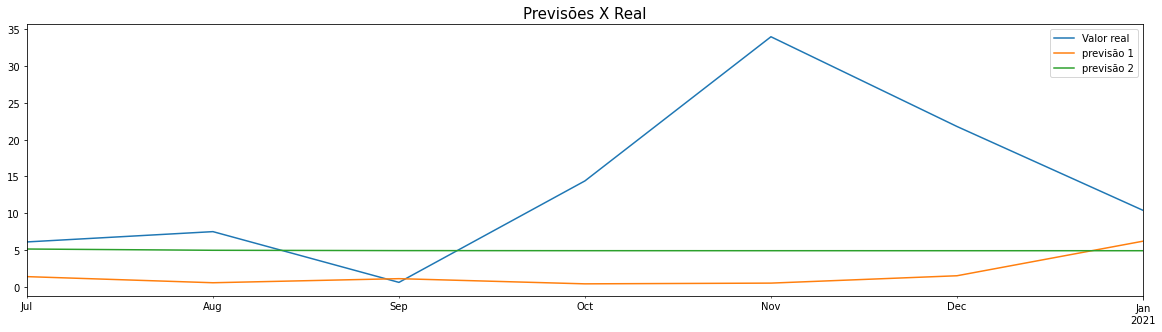

In [67]:
plt.figure(figsize=(20,5))
pd.concat([test,future_forecast,future_forecast1],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','previsão 1','previsão 2'])
plt.show();

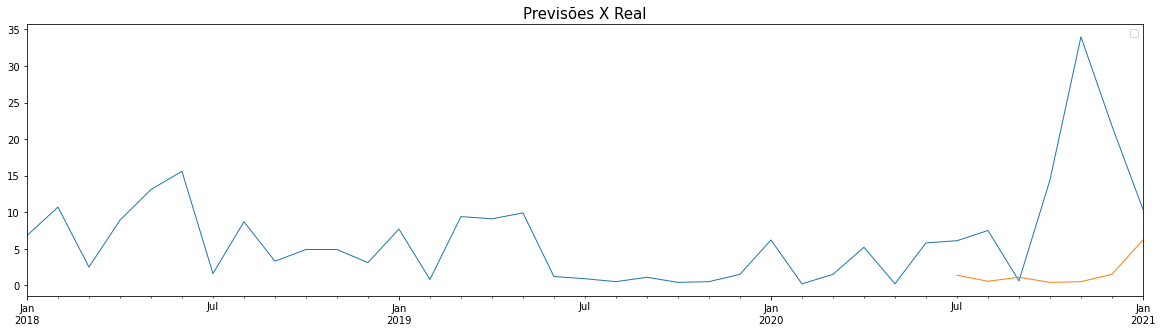

In [68]:
pd.concat([df_sunspots['1999-01-31':],future_forecast],axis=1).plot(linewidth=1,figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

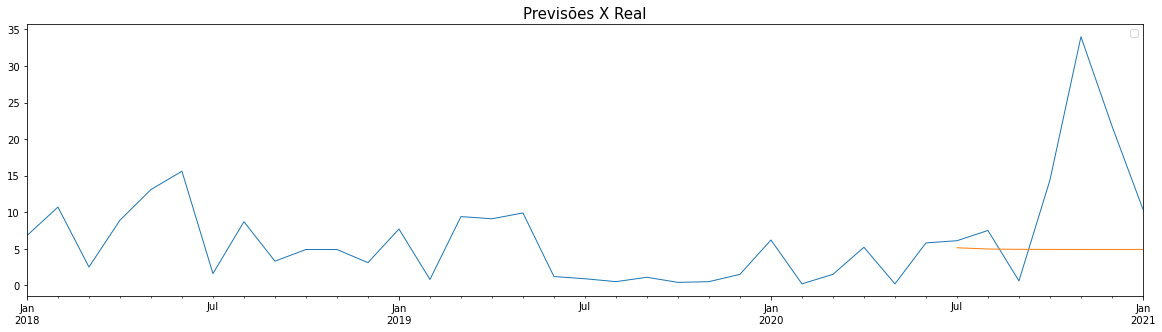

In [69]:
pd.concat([df_sunspots,future_forecast1],axis=1).plot(linewidth=1, figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

In [70]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   30
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -58.049
Date:                            Sun, 12 Nov 2023   AIC                            120.098
Time:                                    15:29:00   BIC                            121.878
Sample:                                01-31-2018   HQIC                           120.343
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1048      0.322      0.325      0.745      -0.527       0.737
sigma2        37.0173     13.164      2.812      0.005      11.217      62.818
===================================================================================
Ljung-Box (L1) (Q):                   3.46   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.06   Prob(JB):                         0.98
Heteroskedasticity (H):               0.51   Skew:                            -0.05
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
stepwise1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -84.657
Date:                Sun, 12 Nov 2023   AIC                            175.315
Time:                        15:29:01   BIC                            179.518
Sample:                    01-31-2018   HQIC                           176.659
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6439      1.337      2.726      0.006       1.024       6.264
ar.L1          0.2572      0.155      1.660      0.097      -0.046       0.561
sigma2        16.5050      6.770      2.438      0.015       3.236      29.774
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.75   Prob(JB):                         0.35
Heteroskedasticity (H):               0.38   Skew:                             0.36
Prob(H) (two-sided):                  0.15   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
# função para calcular o erro dos modelos
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

In [73]:
# Análise dos erros/resíduos, ideal é o mais próximo de zero
check_erro(test,future_forecast)

,
,
VIÉS,NaN
MSE,259.824474
RMSE,16.119072
MAE,12.024604
MAPE,NaN


In [74]:
check_erro(test,future_forecast1)

,
,
VIÉS,NaN
MSE,182.590007
RMSE,13.512587
MAE,9.827589
MAPE,NaN


In [75]:
erros=pd.DataFrame(np.array(future_forecast.values.tolist())-np.array(test.values.tolist()))

erros1=pd.DataFrame(np.array(future_forecast1.values.tolist())-np.array(test.values.tolist()))

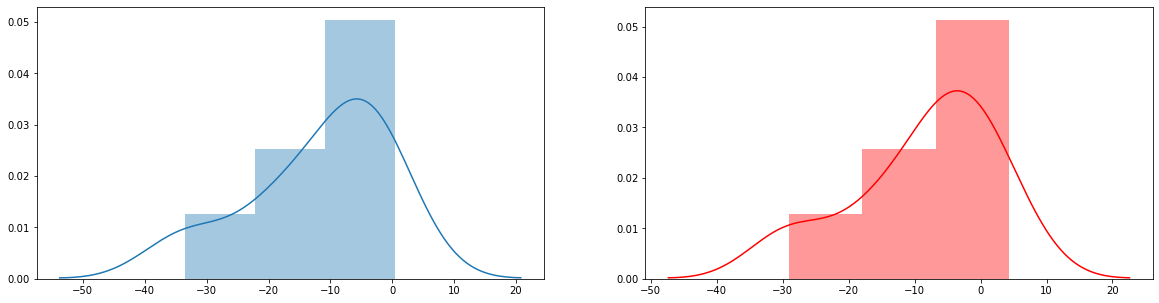

In [76]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(erros,ax=ax[0])
sns.distplot(erros1,ax=ax[1], color='red');

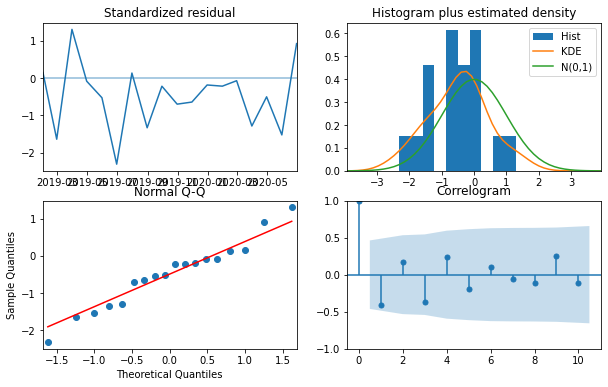

In [77]:
stepwise.plot_diagnostics(figsize=(10,6));

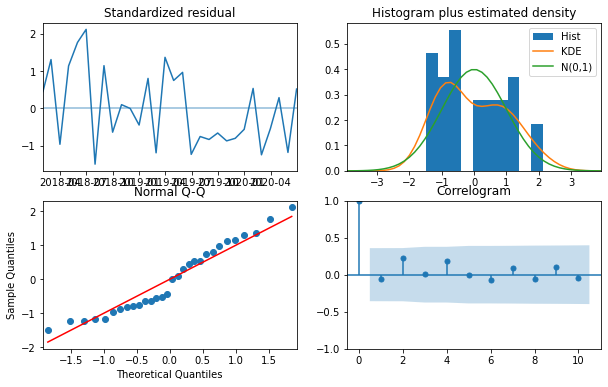

In [78]:
stepwise1.plot_diagnostics(figsize=(10,6));

In [79]:
# Verificado normalidade dos resíduos pelo teste Jarque Bera:
test = jarque_bera(erros)
print('Estatística Jarque-Bera :', test[0])
print('p-valor :', test[1])
print('Assimetria :', test[2])
print('Curtose :',test[3])

Estatística Jarque-Bera : [0.93548125]
p-valor : [0.62641598]
Assimetria : [-0.86969402]
Curtose : [2.5735102]


In [80]:
test1 = jarque_bera(erros1)
print('Estatística Jarque-Bera :', test1[0])
print('p-valor :', test1[1])
print('Assimetria :', test1[2])
print('Curtose :',test1[3])

Estatística Jarque-Bera : [0.79403878]
p-valor : [0.67232099]
Assimetria : [-0.7984852]
Curtose : [2.58514552]


In [81]:
# Aplicando o modelo mais adequado:

stepwise.fit(df)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [110]:
future_forecast2=stepwise1.predict(n_periods=12)

In [111]:
future_forecast2=pd.DataFrame(future_forecast2, 
                              index=pd.date_range(start='2021-02-28',
                                                  end='2022-01-31',freq='M'),columns=['Nova previsão'])


In [113]:
future_forecast2.head(12)

,Nova previsão
2021-02-28,4.905546
2021-03-31,4.905533
2021-04-30,4.905530
2021-05-31,4.905529
2021-06-30,4.905529
2021-07-31,NaN
2021-08-31,NaN
2021-09-30,NaN
2021-10-31,NaN
2021-11-30,NaN


<Figure size 1440x360 with 0 Axes>

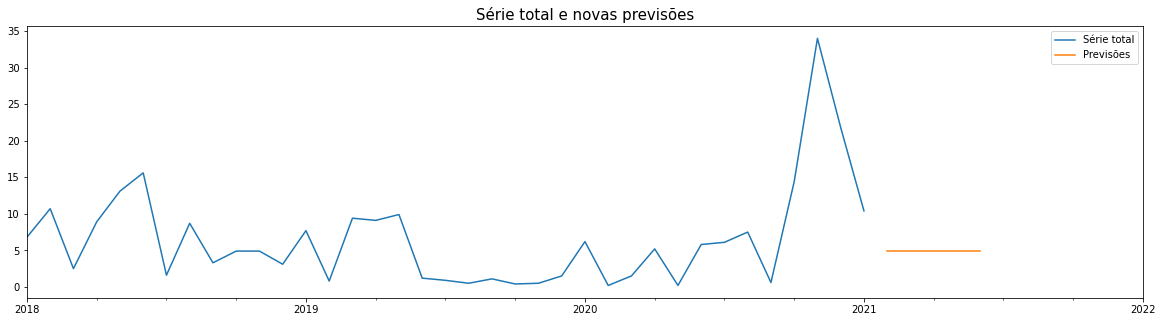

In [119]:
plt.figure(figsize=(20,5))
pd.concat([df_sunspots,future_forecast2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show();